In [1]:
from google.colab import drive

# Mount Google Drive
drive.mount('/content/drive')


Mounted at /content/drive


#PCA

In [2]:
from sklearn.decomposition import PCA

def pca_to_62x62(input_data):

    pca = PCA(n_components=62)
    transformed_data = pca.fit_transform(input_data)
    return transformed_data


#Rescaling


In [3]:
import numpy as np

def rescale_to_0_255(data):

    # Find the minimum and maximum values in the data
    min_val = data.min()
    max_val = data.max()

    # Perform min-max scaling to rescale the data to [0, 255]
    scaled_data = 255 * (data - min_val) / (max_val - min_val)

    return scaled_data.astype(np.uint8)  # Ensure the data type is uint8 for image representation


In [4]:
from sklearn.preprocessing import StandardScaler

def zscale_row_wise(data):
    # Reshape the data to (62 * 1000, ) before scaling
    reshaped_data = data.reshape(-1, 1)

    scaler = StandardScaler()
    scaled_data = scaler.fit_transform(reshaped_data)

    # Reshape the scaled data back to (62, 1000)
    return scaled_data.reshape(data.shape)


In [5]:
!pip install numpy pandas scipy scikit-learn


# Data transformation for noise reduction and dimensionality reduction along with reshaping

In [6]:
import os
import numpy as np
from scipy.io import loadmat
import pandas as pd
from sklearn.preprocessing import StandardScaler

# Define the directory path where the .mat files are located
base_dir = '/content/drive/MyDrive/SEED_IV/SEED_IV/eeg_raw_data'

# Set the batch size
batch_size = 4

# Initialize an empty DataFrame
final_df = pd.DataFrame()

# Define the expected dimensions for reshaping
height, width, channels = 62, 1000, 1  # Modified width for 62 x 1000 matrices

# Traverse through the directories and load .mat files
for folder in os.listdir(base_dir):
    folder_path = os.path.join(base_dir, folder)

    if os.path.isdir(folder_path):
        # Initialize a list to store DataFrames for each batch
        batch_dfs = []

        for file in os.listdir(folder_path):
            if file.endswith('.mat'):
                file_path = os.path.join(folder_path, file)
                data = loadmat(file_path)  # Load .mat file

                # Initialize a DataFrame for each batch
                batch_df = pd.DataFrame()

                # Loop through variables in the loaded .mat file
                for var_key, var_value in data.items():
                    # Skip variables that start with double underscores "__"
                    if var_key.startswith("__"):
                        continue

                    # Define the column name for the DataFrame
                    column_name = f'{folder}_{var_key}'

                    # Find the 1000 most relevant and non-zero values along the timestamp axis
                    relevant_indices = np.abs(var_value).argsort(axis=1)[:, -1000:]
                    relevant_indices.sort(axis=1)

                    # Extract the relevant values
                    relevant_values = np.take_along_axis(var_value, relevant_indices, axis=1)

                    # Reshape the data to 62 x 1000
                    reshaped_data = relevant_values.reshape((height, width, channels))

                    # Create a new column in the DataFrame and assign the reshaped variable
                    batch_df[column_name] = [reshaped_data]

                batch_dfs.append(batch_df)

                # Process the batch once it reaches the specified batch size
                if len(batch_dfs) >= batch_size:
                    batch_df = pd.concat(batch_dfs, axis=1)

                    # Apply preprocessing to the batch (z-scaling)
                    batch_df = batch_df.applymap(zscale_row_wise)
                    # batch_df = batch_df.applymap(rescale_to_0_255)

                    # Append the batch to the final DataFrame
                    final_df = pd.concat([final_df, batch_df], axis=1)
                    batch_dfs = []

        # Process any remaining data in the last batch
        if len(batch_dfs) > 0:
            batch_df = pd.concat(batch_dfs, axis=1)

            # Apply preprocessing to the last batch
            batch_df = batch_df.applymap(zscale_row_wise)
            # batch_df = batch_df.applymap(rescale_to_0_255)

            # Append the last batch to the final DataFrame
            final_df = pd.concat([final_df, batch_df], axis=1)


In [7]:
# import os
# import numpy as np
# from scipy.io import loadmat
# import pandas as pd
# import matplotlib.pyplot as plt

# # Define the directory path where the .mat files are located
# base_dir = '/content/drive/MyDrive/SEED_IV/SEED_IV/eeg_raw_data'

# # Initialize lists to store the shapes of the original data and the corresponding folder
# original_data_shapes = []
# y_axis_sizes = []

# # Traverse through the directories and load .mat files
# for folder in os.listdir(base_dir):
#     folder_path = os.path.join(base_dir, folder)

#     if os.path.isdir(folder_path):
#         for file in os.listdir(folder_path):
#             if file.endswith('.mat'):
#                 file_path = os.path.join(folder_path, file)
#                 data = loadmat(file_path)  # Load .mat file

#                 # Loop through variables in the loaded .mat file
#                 for var_key, var_value in data.items():
#                     # Skip variables that start with double underscores "__"
#                     if var_key.startswith("__"):
#                         continue

#                     # Get the shape of the original data
#                     original_shape = var_value.shape
#                     original_data_shapes.append((folder, var_key, original_shape))
#                     y_axis_sizes.append(original_shape[1])

# # Plot the Y-axis (timestamp) sizes
# plt.figure(figsize=(10, 6))
# plt.bar(range(len(y_axis_sizes)), y_axis_sizes)
# plt.xlabel("Data Point")
# plt.ylabel("Y-Axis Size (Timestamp)")
# plt.title("Range of Y-Axis Sizes")
# plt.show()

# min_y_axis_size = min(y_axis_sizes)
# max_y_axis_size = max(y_axis_sizes)

# print(f"Minimum Y-Axis (Timestamp) Size: {min_y_axis_size}")
# print(f"Maximum Y-Axis (Timestamp) Size: {max_y_axis_size}")


In [8]:
final_df.head()



,1_tyc_eeg1,1_tyc_eeg2,1_tyc_eeg3,1_tyc_eeg4,1_tyc_eeg5,1_tyc_eeg6,1_tyc_eeg7,1_tyc_eeg8,1_tyc_eeg9,1_tyc_eeg10,...,2_rx_eeg15,2_rx_eeg16,2_rx_eeg17,2_rx_eeg18,2_rx_eeg19,2_rx_eeg20,2_rx_eeg21,2_rx_eeg22,2_rx_eeg23,2_rx_eeg24
0,"[[[1.3784339653732112], [1.52158192496], [1.46...","[[[-0.020321331860604995], [-0.004666203310928...","[[[-1.2707157025624802], [-1.1528912880628286]...","[[[1.509842439080777], [1.5125293472348809], [...","[[[1.2722903356783237], [1.3028249395707563], ...","[[[0.8450051576162904], [1.1384872282679337], ...","[[[0.6537646330287641], [0.6476892319835252], ...","[[[1.5165993106846953], [1.6273696398864408], ...","[[[-1.0557735519329114], [-0.9658654815830695]...","[[[0.6345142369623278], [0.676061025155554], [...",...,"[[[0.8847033496277554], [0.8774949335148036], ...","[[[1.9997763481958941], [2.071432092272479], [...","[[[0.8741957430197598], [0.9702690324264942], ...","[[[1.898098422756696], [1.974330209950379], [2...","[[[1.3447656010851081], [1.3562049275702117], ...","[[[0.8931292338926919], [1.119289392108879], [...","[[[0.29810866244076206], [0.3060006397867359],...","[[[1.6786853026007384], [2.0408303281992843], ...","[[[1.4363009754164702], [1.4899316539385985], ...","[[[1.4678834308961712], [1.2384726598621292], ..."


In [9]:
value = final_df.iloc[0, 1079]
print("value:", value.size)


value: 62000


#Labelling

In [10]:
# Sample labels from your provided information
session1_label = [1, 2, 3, 0, 2, 0, 0, 1, 0, 1, 2, 1, 1, 1, 2, 3, 2, 2, 3, 3, 0, 3, 0, 3]
session2_label = [2, 1, 3, 0, 0, 2, 0, 2, 3, 3, 2, 3, 2, 0, 1, 1, 2, 1, 0, 3, 0, 1, 3, 1]
session3_label = [1, 2, 2, 1, 3, 3, 3, 1, 1, 2, 1, 0, 2, 3, 3, 0, 2, 3, 0, 0, 2, 0, 1, 0]

# Sample DataFrame column names
column_names = final_df.columns

# Add a new row for emotion labels
final_df.loc['Emotion_Label'] = [
    session1_label[int(name[-2:]) - 1] if name[0] == '1' and name[-2].isdigit() else
    session1_label[int(name[-1:]) - 1] if name[0] == '1' else
    session2_label[int(name[-2:]) - 1] if name[0] == '2' and name[-2].isdigit() else
    session2_label[int(name[-1:]) - 1] if name[0] == '2' else
    session3_label[int(name[-2:]) - 1] if name[0] == '3' and name[-2].isdigit() else
    session3_label[int(name[-1:]) - 1] if name[0] == '3' else 20
 for name in column_names
]


In [11]:
# Convert labels to integers
label_mapping = {'Class 0': 0, 'Class 1': 1, 'Class 2': 2, 'Class 3': 3}
final_df = final_df.replace({'Emotion_Label': label_mapping})

In [12]:
final_df.head()


,1_tyc_eeg1,1_tyc_eeg2,1_tyc_eeg3,1_tyc_eeg4,1_tyc_eeg5,1_tyc_eeg6,1_tyc_eeg7,1_tyc_eeg8,1_tyc_eeg9,1_tyc_eeg10,...,2_rx_eeg15,2_rx_eeg16,2_rx_eeg17,2_rx_eeg18,2_rx_eeg19,2_rx_eeg20,2_rx_eeg21,2_rx_eeg22,2_rx_eeg23,2_rx_eeg24
0,"[[[1.3784339653732112], [1.52158192496], [1.46...","[[[-0.020321331860604995], [-0.004666203310928...","[[[-1.2707157025624802], [-1.1528912880628286]...","[[[1.509842439080777], [1.5125293472348809], [...","[[[1.2722903356783237], [1.3028249395707563], ...","[[[0.8450051576162904], [1.1384872282679337], ...","[[[0.6537646330287641], [0.6476892319835252], ...","[[[1.5165993106846953], [1.6273696398864408], ...","[[[-1.0557735519329114], [-0.9658654815830695]...","[[[0.6345142369623278], [0.676061025155554], [...",...,"[[[0.8847033496277554], [0.8774949335148036], ...","[[[1.9997763481958941], [2.071432092272479], [...","[[[0.8741957430197598], [0.9702690324264942], ...","[[[1.898098422756696], [1.974330209950379], [2...","[[[1.3447656010851081], [1.3562049275702117], ...","[[[0.8931292338926919], [1.119289392108879], [...","[[[0.29810866244076206], [0.3060006397867359],...","[[[1.6786853026007384], [2.0408303281992843], ...","[[[1.4363009754164702], [1.4899316539385985], ...","[[[1.4678834308961712], [1.2384726598621292], ..."
Emotion_Label,1,2,3,0,2,0,0,1,0,1,...,1,1,2,1,0,3,0,1,3,1


#Data split

In [26]:
import numpy as np
from sklearn.model_selection import train_test_split

# Assuming Image_Matrix and Label are your DataFrames
# Extract the data and labels
Image_Matrix = final_df.iloc[0, :].to_list()
Label = final_df.iloc[1, :].to_list()

# Define X as the input data (images)
X = np.array(Image_Matrix).reshape(-1, 62, 1000, 1)

# Define y as the labels
y = np.array(Label)

# Calculate the index to split at
split_index = int(len(X) * (2/3))

# Assuming X and y are your data and labels
# Define the size of the training set
train_size = 16

# Define the size of the testing set
test_size = 8

# Define the starting index for the pattern
start_index = 0

# Define the ending index for the pattern (720 in this case)
end_index = 359

# Initialize empty lists to store training and testing indices
train_indices = []
test_indices = []

# Populate the training and testing indices based on the described pattern
for i in range(start_index, min(end_index, len(X)), train_size + test_size):
    train_indices.extend(range(i - train_size, i))
    test_indices.extend(range(i, i + test_size))

# Extract training and testing data based on the indices
X_train, y_train = X[train_indices], y[train_indices]
X_test, y_test = X[test_indices], y[test_indices]

# Further split the training data into training (50%) and validation (50%)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.5, random_state=None)


In [27]:
# print("Data types and shapes:")
# print("X_train:", type(X_train), X_train.shape if hasattr(X_train, 'shape') else None)
# print("X_val:", type(X_val), X_val.shape if hasattr(X_val, 'shape') else None)
# print("X_test:", type(X_test), X_test.shape if hasattr(X_test, 'shape') else None)
# print("y_train:", type(y_train), y_train.shape if hasattr(y_train, 'shape') else None)
# print("y_val:", type(y_val), y_val.shape if hasattr(y_val, 'shape') else None)
# print("y_test:", type(y_test), y_test.shape if hasattr(y_test, 'shape') else None)

# # Check the data type of the first element in X_train
# if len(X_train) > 0:
#     print("Data type of the first element in X_train:", type(X_train[0]))
# else:
#     print("X_train is empty.")

# # Check the data type of the first element in y_train
# if len(y_train) > 0:
#     print("Data type of the first element in y_train:", type(y_train[0]))
# else:
#     print("y_train is empty.")


In [28]:
# print(X_train.dtype)

In [29]:
# print(y_train.dtype)

In [30]:
# X_train = X_train.numpy()
# y_train = y_train.numpy()
# X_val = X_val.numpy()
# y_val = y_val.numpy()
# X_test = X_test.numpy()
# y_test = y_test.numpy()


In [31]:
# import matplotlib.pyplot as plt

# # Visualize some EEG data samples
# sample_indices = [0, 1, 2]
# for index in sample_indices:
#     sample_image = X_train[index].reshape(62, 1000)  # Reshape to (62, 62)
#     label = y_train[index]

#     plt.figure()
#     plt.imshow(sample_image, cmap='viridis')
#     plt.title(f"Sample EEG Data - Label: {label}")
#     plt.show()


# CNN model


7/7 [==============================] - 0s 13ms/step - loss: 1.9019 - accuracy: 0.3056
Average Training Accuracy: 0.9236111164093017
Average Validation Accuracy: 0.3009259283542633
4/4 [==============================] - 0s 14ms/step - loss: 0.3589 - accuracy: 0.8917
Test accuracy: 0.8916666507720947
Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_20 (Conv2D)          (None, 60, 998, 32)       320       
                                                                 
 max_pooling2d_20 (MaxPooli  (None, 30, 499, 32)       0         
 ng2D)                                                           
                                                                 
 conv2d_21 (Conv2D)          (None, 28, 497, 64)       18496     
                                                                 
 max_pooling2d_21 (MaxPooli  (None, 14, 248, 64)       0         
 ng2D)           

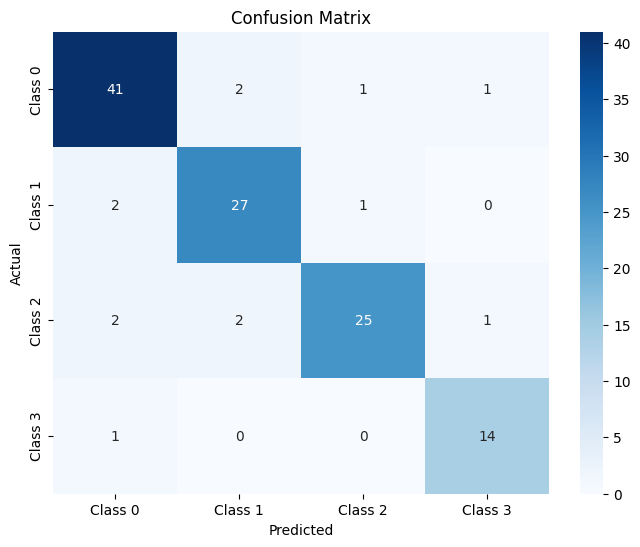

In [32]:
import tensorflow as tf
from tensorflow import keras

import numpy as np
from sklearn.model_selection import StratifiedKFold

#  feature and label matrices
X = np.array(Image_Matrix).reshape(-1, 62, 1000, 1)
y = np.array(Label)

# Set the number of folds
num_folds = 5
skf = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)

# Lists to store the results for each fold
all_train_acc = []
all_val_acc = []

# Loop through the folds
for train_index, val_index in skf.split(X, y):
    X_train, X_val = X[train_index], X[val_index]
    y_train, y_val = y[train_index], y[val_index]

    # Create and compile the model
    model = keras.Sequential([
        keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(62, 1000, 1)),
        keras.layers.MaxPooling2D((2, 2)),
        keras.layers.Conv2D(64, (3, 3), activation='relu'),
        keras.layers.MaxPooling2D((2, 2)),
        keras.layers.Flatten(),
        keras.layers.Dense(128, activation='relu'),
        keras.layers.Dropout(0.5),
        keras.layers.Dense(4, activation='softmax')
    ])
    model.compile(optimizer='adam',
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])

    # Train the model
    history = model.fit(X_train, y_train, epochs=8, validation_data=(X_val, y_val), verbose=0)

    # Evaluate on training and validation sets
    train_loss, train_acc = model.evaluate(X_train, y_train)
    val_loss, val_acc = model.evaluate(X_val, y_val)

    # Append results to lists
    all_train_acc.append(train_acc)
    all_val_acc.append(val_acc)

# Calculate and print the average accuracy across folds
avg_train_acc = np.mean(all_train_acc)
avg_val_acc = np.mean(all_val_acc)
print(f'Average Training Accuracy: {avg_train_acc}')
print(f'Average Validation Accuracy: {avg_val_acc}')


# Evaluate the model on the test set
test_loss, test_acc = model.evaluate(X_test, y_test)
print("Test accuracy:", test_acc)

# Display the model summary
model.summary()

# Visualize the confusion matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
cm = confusion_matrix(y_test, y_pred_classes)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Class 0', 'Class 1', 'Class 2', 'Class 3'], yticklabels=['Class 0', 'Class 1', 'Class 2', 'Class 3'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()


In [33]:
# Assuming y_train and X_train are available
y_train_probs = model.predict(X_train)
y_train_pred = np.argmax(y_train_probs, axis=1)


27/27 [==============================] - 0s 15ms/step


In [34]:
print("Actual Labels:", y_train[:10])
print("Predicted Labels:", y_train_pred[:10])


Actual Labels: [1 2 3 0 2 0 0 1 0 1]
Predicted Labels: [1 2 3 0 2 0 0 1 0 1]


In [35]:
train_loss, train_acc = model.evaluate(X_train, y_train)
print(f"Training accuracy: {train_acc}")


27/27 [==============================] - 0s 13ms/step - loss: 0.1038 - accuracy: 0.9977
Training accuracy: 0.9976851940155029


In [36]:
model.summary()


Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_20 (Conv2D)          (None, 60, 998, 32)       320       
                                                                 
 max_pooling2d_20 (MaxPooli  (None, 30, 499, 32)       0         
 ng2D)                                                           
                                                                 
 conv2d_21 (Conv2D)          (None, 28, 497, 64)       18496     
                                                                 
 max_pooling2d_21 (MaxPooli  (None, 14, 248, 64)       0         
 ng2D)                                                           
                                                                 
 flatten_10 (Flatten)        (None, 222208)            0         
                                                                 
 dense_20 (Dense)            (None, 128)             

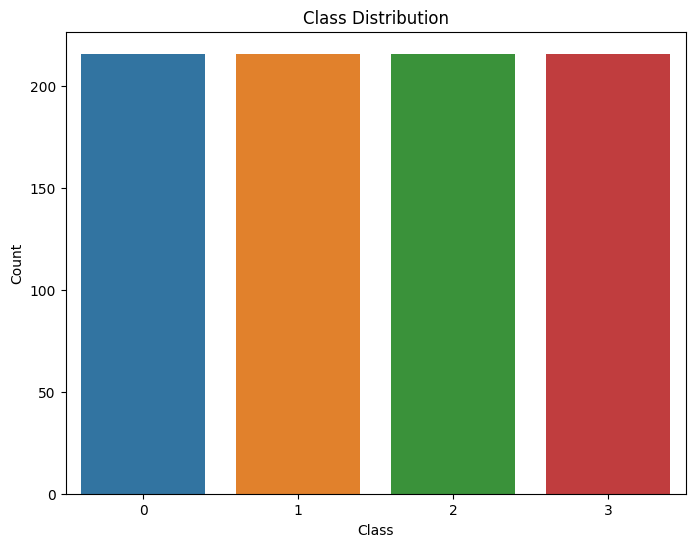

In [37]:
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming y_train contains your class labels
plt.figure(figsize=(8, 6))
sns.countplot(x=y_train)
plt.title('Class Distribution')
plt.xlabel('Class')
plt.ylabel('Count')
plt.show()



7/7 [==============================] - 0s 13ms/step - loss: 1.6952 - accuracy: 0.2685
Average Training Accuracy: 0.9717592716217041
Average Validation Accuracy: 0.2981481492519379
4/4 [==============================] - 0s 12ms/step - loss: 0.8364 - accuracy: 0.7417
Test accuracy: 0.7416666746139526
Model: "sequential_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_30 (Conv2D)          (None, 60, 998, 32)       320       
                                                                 
 max_pooling2d_30 (MaxPooli  (None, 30, 499, 32)       0         
 ng2D)                                                           
                                                                 
 conv2d_31 (Conv2D)          (None, 28, 497, 64)       18496     
                                                                 
 max_pooling2d_31 (MaxPooli  (None, 14, 248, 64)       0         
 ng2D)           

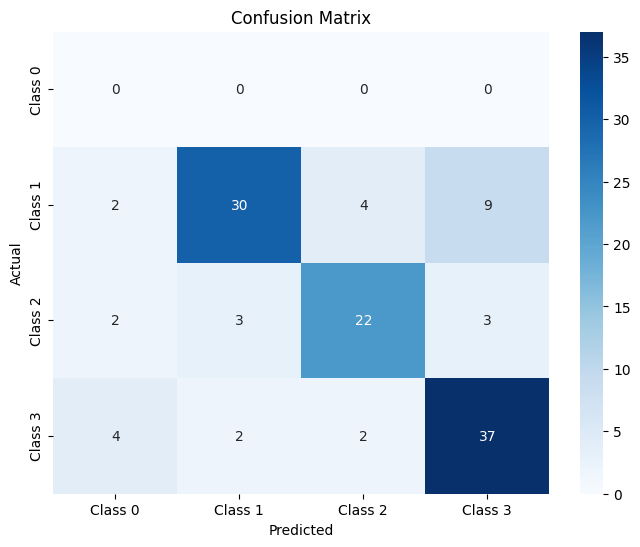

In [38]:
import numpy as np
from sklearn.model_selection import train_test_split

# Assuming Image_Matrix and Label are your DataFrames
# Extract the data and labels
Image_Matrix = final_df.iloc[0, :].to_list()
Label = final_df.iloc[1, :].to_list()

# Define X as the input data (images)
X = np.array(Image_Matrix).reshape(-1, 62, 1000, 1)

# Define y as the labels
y = np.array(Label)

# Calculate the index to split at
split_index = int(len(X) * (2/3))

# Assuming X and y are your data and labels
# Define the size of the training set
train_size = 16

# Define the size of the testing set
test_size = 8

# Define the starting index for the pattern
start_index = 360

# Define the ending index for the pattern (720 in this case)
end_index = 719

# Initialize empty lists to store training and testing indices
train_indices = []
test_indices = []

# Populate the training and testing indices based on the described pattern
for i in range(start_index, min(end_index, len(X)), train_size + test_size):
    train_indices.extend(range(i - train_size, i))
    test_indices.extend(range(i, i + test_size))

# Extract training and testing data based on the indices
X_train, y_train = X[train_indices], y[train_indices]
X_test, y_test = X[test_indices], y[test_indices]

# Further split the training data into training (50%) and validation (50%)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.5, random_state=None)


import tensorflow as tf
from tensorflow import keras

import numpy as np
from sklearn.model_selection import StratifiedKFold

#  feature and label matrices
X = np.array(Image_Matrix).reshape(-1, 62, 1000, 1)
y = np.array(Label)

# Set the number of folds
num_folds = 5
skf = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)

# Lists to store the results for each fold
all_train_acc = []
all_val_acc = []

# Loop through the folds
for train_index, val_index in skf.split(X, y):
    X_train, X_val = X[train_index], X[val_index]
    y_train, y_val = y[train_index], y[val_index]

    # Create and compile the model
    model = keras.Sequential([
        keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(62, 1000, 1)),
        keras.layers.MaxPooling2D((2, 2)),
        keras.layers.Conv2D(64, (3, 3), activation='relu'),
        keras.layers.MaxPooling2D((2, 2)),
        keras.layers.Flatten(),
        keras.layers.Dense(128, activation='relu'),
        keras.layers.Dropout(0.5),
        keras.layers.Dense(4, activation='softmax')
    ])
    model.compile(optimizer='adam',
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])

    # Train the model
    history = model.fit(X_train, y_train, epochs=8, validation_data=(X_val, y_val), verbose=0)

    # Evaluate on training and validation sets
    train_loss, train_acc = model.evaluate(X_train, y_train)
    val_loss, val_acc = model.evaluate(X_val, y_val)

    # Append results to lists
    all_train_acc.append(train_acc)
    all_val_acc.append(val_acc)

# Calculate and print the average accuracy across folds
avg_train_acc = np.mean(all_train_acc)
avg_val_acc = np.mean(all_val_acc)
print(f'Average Training Accuracy: {avg_train_acc}')
print(f'Average Validation Accuracy: {avg_val_acc}')


# Evaluate the model on the test set
test_loss, test_acc = model.evaluate(X_test, y_test)
print("Test accuracy:", test_acc)

# Display the model summary
model.summary()

# Visualize the confusion matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
cm = confusion_matrix(y_test, y_pred_classes)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Class 0', 'Class 1', 'Class 2', 'Class 3'], yticklabels=['Class 0', 'Class 1', 'Class 2', 'Class 3'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()


7/7 [==============================] - 0s 13ms/step - loss: 2.1387 - accuracy: 0.2593
Average Training Accuracy: 0.9493055582046509
Average Validation Accuracy: 0.2657407373189926
4/4 [==============================] - 0s 13ms/step - loss: 0.5655 - accuracy: 0.8417
Test accuracy: 0.8416666388511658
Model: "sequential_20"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_40 (Conv2D)          (None, 60, 998, 32)       320       
                                                                 
 max_pooling2d_40 (MaxPooli  (None, 30, 499, 32)       0         
 ng2D)                                                           
                                                                 
 conv2d_41 (Conv2D)          (None, 28, 497, 64)       18496     
                                                                 
 max_pooling2d_41 (MaxPooli  (None, 14, 248, 64)       0         
 ng2D)           

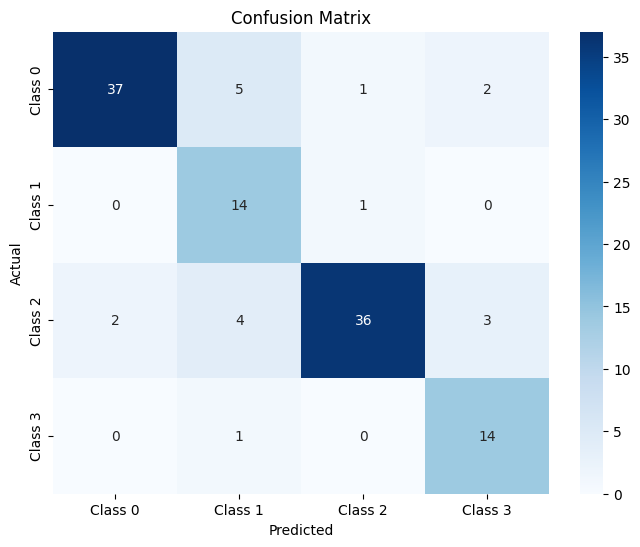

In [39]:
import numpy as np
from sklearn.model_selection import train_test_split

# Assuming Image_Matrix and Label are your DataFrames
# Extract the data and labels
Image_Matrix = final_df.iloc[0, :].to_list()
Label = final_df.iloc[1, :].to_list()

# Define X as the input data (images)
X = np.array(Image_Matrix).reshape(-1, 62, 1000, 1)

# Define y as the labels
y = np.array(Label)

# Calculate the index to split at
split_index = int(len(X) * (2/3))

# Assuming X and y are your data and labels
# Define the size of the training set
train_size = 16

# Define the size of the testing set
test_size = 8

# Define the starting index for the pattern
start_index = 720

# Define the ending index for the pattern (720 in this case)
end_index = 1079

# Initialize empty lists to store training and testing indices
train_indices = []
test_indices = []

# Populate the training and testing indices based on the described pattern
for i in range(start_index, min(end_index, len(X)), train_size + test_size):
    train_indices.extend(range(i - train_size, i))
    test_indices.extend(range(i, i + test_size))

# Extract training and testing data based on the indices
X_train, y_train = X[train_indices], y[train_indices]
X_test, y_test = X[test_indices], y[test_indices]

# Further split the training data into training (50%) and validation (50%)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.5, random_state=None)


import tensorflow as tf
from tensorflow import keras

import numpy as np
from sklearn.model_selection import StratifiedKFold

#  feature and label matrices
X = np.array(Image_Matrix).reshape(-1, 62, 1000, 1)
y = np.array(Label)

# Set the number of folds
num_folds = 5
skf = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)

# Lists to store the results for each fold
all_train_acc = []
all_val_acc = []

# Loop through the folds
for train_index, val_index in skf.split(X, y):
    X_train, X_val = X[train_index], X[val_index]
    y_train, y_val = y[train_index], y[val_index]

    # Create and compile the model
    model = keras.Sequential([
        keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(62, 1000, 1)),
        keras.layers.MaxPooling2D((2, 2)),
        keras.layers.Conv2D(64, (3, 3), activation='relu'),
        keras.layers.MaxPooling2D((2, 2)),
        keras.layers.Flatten(),
        keras.layers.Dense(128, activation='relu'),
        keras.layers.Dropout(0.5),
        keras.layers.Dense(4, activation='softmax')
    ])
    model.compile(optimizer='adam',
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])

    # Train the model
    history = model.fit(X_train, y_train, epochs=8, validation_data=(X_val, y_val), verbose=0)

    # Evaluate on training and validation sets
    train_loss, train_acc = model.evaluate(X_train, y_train)
    val_loss, val_acc = model.evaluate(X_val, y_val)

    # Append results to lists
    all_train_acc.append(train_acc)
    all_val_acc.append(val_acc)

# Calculate and print the average accuracy across folds
avg_train_acc = np.mean(all_train_acc)
avg_val_acc = np.mean(all_val_acc)
print(f'Average Training Accuracy: {avg_train_acc}')
print(f'Average Validation Accuracy: {avg_val_acc}')


# Evaluate the model on the test set
test_loss, test_acc = model.evaluate(X_test, y_test)
print("Test accuracy:", test_acc)

# Display the model summary
model.summary()

# Visualize the confusion matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
cm = confusion_matrix(y_test, y_pred_classes)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Class 0', 'Class 1', 'Class 2', 'Class 3'], yticklabels=['Class 0', 'Class 1', 'Class 2', 'Class 3'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()


In [41]:
mean=(0.8916666507720947+0.7416666746139526+0.8416666388511658)/3
print(mean)

0.824999988079071
